In [1]:
import os
os.chdir('..')

import logging
logging.basicConfig(level=logging.ERROR)
from janusq.simulator.noisy_simulator import NoisySimulator
from janusq.data_objects.backend import LinearBackend
from janusq.simulator.readout_error_model import ReadoutErrorModel
from janusq.optimizations.readout_mitigation.fem import Mitigator
from janusq.optimizations.readout_mitigation.fem import IterativeSamplingProtocol, EnumeratedProtocol
from janusq.data_objects.algorithms import get_algorithm_circuits, ibu_response_matrix
from qiskit.quantum_info.analysis import hellinger_fidelity
from janusq.optimizations.readout_mitigation.fem.tools import npformat_to_statuscnt,statuscnt_to_npformat
from time import time
import matplotlib.pyplot as plt

# Readout Calibration Of JanusQ-FEM on Quantum Simualtor

**Author:** Hanyu Zhang \& Siwei Tan

**Date:** 9/4/2024

Based on paper "[QuFEM: Fast and Accurate Quantum Readout Calibration Using the Finite Element Method][1]"

[1]: https://scholar.google.com/scholar_url?url=https://dl.acm.org/doi/abs/10.1145/3613424.3614274%3Fcasa_token%3DffjIB1hQ4ZwAAAAA:8MajDLrDOC74WoeMf7r7AoQ-koxCa4E1TNqQg3GSDz03xUX6XdE3toNTM-YdM_e4rKEusMceJ6BGJg&hl=zh-CN&sa=T&oi=gsb&ct=res&cd=0&d=11146218754516883150&ei=42YSZpPlFL6s6rQPtt6x6Ac&scisig=AFWwaeYaiu2hyx8HUJ_7Buf9Mwom


Quantum readout is the operation that read the information from quantum bits (qubits) into classical bits. Quantum readout noise turns out to be the most significant source of error, which greatly affects the measurement fidelity. In most quantum algorithms, outputs are probability distributions of bit strings, obtained through repeated circuit executions. These bit strings exist in a space represented by $\left \{ 0,1 \right \} ^{N_q}$, where $N_q$ is the number of qubits. The observed probability of a specific bit string reflects its amplitude in the measured quantum superposition state.

## Background: Matrix-based Calibration

For program output that is a probability distribution. Readout error perturbs this probability distribution, expressed as a linear transformation from the ideal distribution $P_{\text{ideal}}$ to the measured distribution $P_{\text{measured}}$:

$$
\begin{equation*} 
\small
P_{measured} = M P_{ideal},
\end{equation*}
$$
where $M$ is defined as the noise matrix with the size of $2^{N_q} \times 2^{N_q}$. $2^{N_q}$ is the number of qubits. Theoretically, the noise matrix can be characterized by running benchmarking circuits with every basis state as input.

<div style="text-align:center;">
    <img src="./pictures/3-1.background.jpg"  width="50%" height="50%">
</div>


As shown in the figure above, the calibration consists of two steps. In the characterization, $2^{N_q}$ benchmarking circuits are executed, preparing all possible basis states (no superposition). We assume the initial state to be ideal, prepared by high-fidelity single-qubit gates. The noise matrix is then filled based on the output probability distribution after execution:

$$
\begin{equation*} 
\begin{aligned}
& M[x][y]=P(measure=x ~~|~~ prepare=y).
\end{aligned}
\end{equation*}
$$

After getting the noise matrix $M$, we can calibrate any measured probability distribution from this quantum device using its inverse $M^{-1}$, namely calibration matrix. The calibration is conducted via an MVM operator between the measured distribution and the calibration matrix:
$$
\begin{equation*} 
\small
P_{calibrated} = M^{-1} P_{measured}.
\end{equation*}
$$
The step 2 in Figure is an example of a 2-qubit calibration. For example, for a two-qubit calibration, we needs to run following quantum circuits and apply calibration for given output.


In [2]:

n_qubits = 5
backend = LinearBackend(n_qubits, 1)
circuit = get_algorithm_circuits(n_qubits, backend, algs = ['ghz'])[0]
print(circuit)

     ┌────────────┐ ░       ░       ░       ░       ░ 
q_0: ┤ U(π/2,0,π) ├─░───■───░───────░───────░───────░─
     └────────────┘ ░ ┌─┴─┐ ░       ░       ░       ░ 
q_1: ───────────────░─┤ X ├─░───■───░───────░───────░─
                    ░ └───┘ ░ ┌─┴─┐ ░       ░       ░ 
q_2: ───────────────░───────░─┤ X ├─░───■───░───────░─
                    ░       ░ └───┘ ░ ┌─┴─┐ ░       ░ 
q_3: ───────────────░───────░───────░─┤ X ├─░───■───░─
                    ░       ░       ░ └───┘ ░ ┌─┴─┐ ░ 
q_4: ───────────────░───────░───────░───────░─┤ X ├─░─
                    ░       ░       ░       ░ └───┘ ░ 


Calibrating 5-qubit GHZ algorithm using matrix-based calibration method


- Running benchmark circuits to generate calibration matrices

In [3]:
samples = 10000

# define a backend and simulator with random readout errors
simulator = NoisySimulator(
    backend, readout_error_model = ReadoutErrorModel.random_model(backend))
output_noise = simulator.execute(circuit,samples)


protocol = EnumeratedProtocol(n_qubits)
real_bstrs, circuits_protocol = protocol.gen_circuits()

all_statuscnts = [
    simulator.execute(cir_protocol, samples)
    for cir_protocol in circuits_protocol
]

protocol_dataset = [statuscnt_to_npformat(p) for p in all_statuscnts]
protocol_dataset_all =  [[x, y] for x, y in zip(real_bstrs, protocol_dataset)]
protocol_statuscnts = [npformat_to_statuscnt(protocol_dataset_all[i][1]) for i in range(len(protocol_dataset_all))]
bstrs = [protocol_dataset_all[i][0] for i in range(len(protocol_dataset_all))]

- Matrix-vector multiplication calibration

In [4]:
mitigator = Mitigator(n_qubits, n_iters = 1)
scores = mitigator.init((bstrs, protocol_statuscnts), group_size = n_qubits, partation_methods=[
                         'random'],multi_process=False)

output_matrix = npformat_to_statuscnt(mitigator.mitigate(output_noise))
out_ideal = {'1'*n_qubits:samples*0.5,'0'*n_qubits:samples*0.5}

print("Uncalibrated Algorithm Fidelity : ",hellinger_fidelity(out_ideal,output_noise))
print("Calibrated Algorithm Fidelity : ",hellinger_fidelity(out_ideal,output_matrix))

Uncalibrated Algorithm Fidelity :  0.7732289639858829
Calibrated Algorithm Fidelity :  0.9852675161901183


The existing methodologies[<sup>[4]</sup>](#R4)[<sup>[5]</sup>](#R5)[<sup>[6]</sup>](#R6) are fundamentally limited in either scalability or accuracy. Inspired by the classical finite element method (FEM), JanusQ-FEM calibrate the measurement error using finite element method. It reduces the time complexity of benchmarking circuits for noise matrix characterization from exponential $\mathscr{O}(2^n)$ to polynomial $\mathscr{O}(n^2)$ and accelerates the end-to-end calibration.

<div style="text-align:center;">
    <img src="./pictures/3-1.fem.jpg"  width="80%" height="80%">
</div>

JanusQ-FEM divides the qubits involved in the measured circuit output into multiple groups. It defines the circuit output $P_{measured}$ as $P_{1}$, and the calibration output $P_{calibrated}$ as $P_{L+1}$. Janus-FEM reformulates the calibration as an iterative process with a series of sub-noise matrices.
$$
\begin{aligned} 
    \text{Iter. 1:~~~} & P_{2} = (M_{1,1} \otimes M_{1,2} \otimes \cdots M_{1,K})^{-1} P_{1}, \\
    \text{Iter. 2:~~~} & P_{3} = (M_{2,1} \otimes M_{2,2} \otimes \cdots M_{2,K})^{-1} P_{2}, \\
    &  \cdots, \\
    \text{Iter. $L$:~~~} & P_{L+1} = (M_{L,1} \otimes M_{L,2} \otimes \cdots M_{L,K})^{-1} P_{L}, \\
\end{aligned}
$$
where $M_{i,j}$ is the sub-noise matrix of the $j^{{\th}}$ qubit group in the $i^{{\th}}$ iteration. $\otimes$ is the tensor-product to composite these sub-noise matrices. $P_2$ to $P_L$ serve as the intermediate probability distributions that iteratively approximate the ideal probability distribution.

## JanusQ-FEM Characterization
The characterization of JanusQ-FEM aims to collect data for matrix generation by running benchmarking circuits. JanusQ-CT applies a adaptive method that identifies high interactions and prunes unnecessary benchmarking circuits that involving low interactions.

The readout error is state-independent, which means that the error varies when the qubit stays in different states.
Besides, the interactions from one qubit to another vary under different operations, i.e., state preparation and readout, leading to different readout errors.
For example, the figure below presents the readout error of qubit $q_1$ under the prepared states and readout operation of different qubits on the IBMQ Perth quantum device. $\varnothing$ means that the qubit in the axies is not measuerd. The readout error of qubit $q_1$ increases by 0.12\% when it is in $\ket{1}$ compared to when it is in $\ket{0}$. The  error of qubit $q_1$ also decreases by around 0.11\% when qubit $q_5$ is not measured. 

<div style="text-align:center;">
    <img src="./pictures/3-1.error_chracterizaion.jpg"  width="40%" height="40%">
</div>

Based on the observation, JanusQ-CT defines a metric $\theta$ to distinguish the critical interaction.
$$
    \begin{aligned}
        \theta = \frac{interact(q_i.ideal=x \rightarrow q_j.ideal=y)}{num(q_i.ideal=x \rightarrow q_j.ideal=y)}  \\
    \end{aligned}
$$
 $\theta$ naturally decreases with the number of benchmarking circuits. We set a threshold $\alpha$ to specify the desired accuracy and reduce the number of benchmarking circuits.


In [5]:
# run characterization method of JanusQ-FEM
protocol_iterative = IterativeSamplingProtocol(backend, hyper = 1, n_samples_iter = 5)
statuscnts = protocol_iterative.get_data(protocol_dataset_all)     

protocol_statuscnts = [npformat_to_statuscnt(statuscnts[i][1]) for i in range(len(statuscnts))]
bstrs = [statuscnts[i][0] for i in range(len(statuscnts))]


print("The baseline requires : ", len(all_statuscnts), "benchmarking circuits")
print("JanusQ-FEM requires", len(statuscnts), "benchmarking circuits")

/JanusQ/janusq/optimizations/readout_mitigation/fem/benchmarking.py:249: RuntimeWarning: invalid value encountered in divide
  iter_states_error = states_error / states_count


The baseline requires :  242 benchmarking circuits
JanusQ-FEM requires 135 benchmarking circuits


#### Mitigator Construction

**Weighted Graph Construction and Qubit Partition**

JanusQ-FEM uses various grouping schemes in calibration to address local qubit interactions, aiming to maximize locality within groups. To achieve this, qubit interactions are quantified using a weighted graph.
For each shot of the circuit execution, the operation and the readout output of a qubit are recorded as a triple:
- *ideal* $\in \{0, 1, \varnothing\}$: This value records the ideal~(initial) basis state that the qubit is prepared in the circuit.
- *measured* $\in \{0, 1, \varnothing\}$: This value records the measured output of the qubit in this shot.
- *ef* $\in \{0, 1\}$: This is the abbreviation of the error flag, where 0 means the measured output matches the ideal result, and 1 means the error occurs.

An interaction $q_i.ideal=x \rightarrow q_j.ideal=y$ is defined as:
\begin{equation*} 
    \begin{aligned}
        &\text{interact}(q_i.\text{ideal}=x \rightarrow q_j.\text{ideal}=y)= \\
        & ~~~~~~~~~~~\big| p(q_j.\text{ef}=1~|~C1, C2)-p(q_j.\text{ef}=1~|~C2)\big|\\
        & \text{C1: } q_i.\text{ideal}=x,~~~\text{C2: } q_j.\text{ideal}=y
    \end{aligned}
\end{equation*}
where $x \in \{0, 1, \varnothing\}$, $y \in \{0, 1\}$.

The weight between two qubits by collecting all cases of interactions:
\begin{equation*} 
\begin{aligned}
    weight(q_i,q_j) = & \sum_{\mathclap{x\in\{0, 1, \varnothing\}, y\in\{0,1\}}} \text{interact}(q_i.\text{ideal}=x \rightarrow q_j.\text{ideal}=y) \\
    + & \sum_{\mathclap{x\in\{0, 1, \varnothing\}, y\in\{0,1\}}} \text{interact}(q_j.\text{ideal}=x \rightarrow q_i.\text{ideal}=y) 
\end{aligned} 
\end{equation*}
We then construct a qubit graph. The edge of the graph is labeled by the weight. We leverage the MAX-CUT solver to partition qubits in the graph into groups.

135it [00:05, 25.56it/s]


<Figure size 640x480 with 0 Axes>

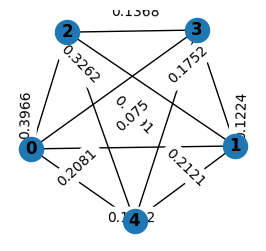

135it [00:02, 59.34it/s]


<Figure size 640x480 with 0 Axes>

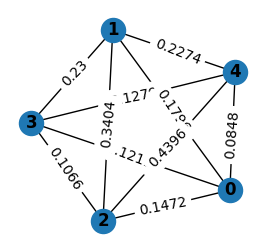

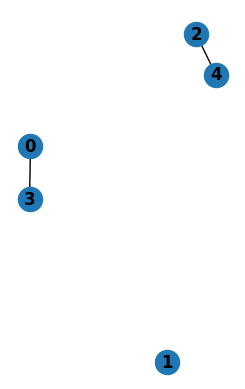

In [6]:
# weighted graph construction

mitigator = Mitigator(n_qubits, n_iters = 2)
scores = mitigator.init((bstrs, protocol_statuscnts), group_size=2, partation_methods=[
                         'max-cut'],multi_process=False, draw_grouping=True)

## JanusQ-FEM Calibration

In [7]:
t_fem_1 = time()
output_fem = npformat_to_statuscnt(mitigator.mitigate(output_noise))
t_fem_2 = time()
t_fem = t_fem_2-t_fem_1
print("Algorithm Fidelity with Janus-FEM using max-cut method: ",hellinger_fidelity(out_ideal,output_fem))
print("Janus-FEM time: ",t_fem)

scores_random = mitigator.init((bstrs, protocol_statuscnts), group_size=2, partation_methods=[
                         'random'],multi_process=False)
output_fem_rd = npformat_to_statuscnt(mitigator.mitigate(output_noise))
print("Algorithm Fidelity with Janus-FEM using random method': ",hellinger_fidelity(out_ideal,output_fem_rd))

Algorithm Fidelity with Janus-FEM using max-cut method:  0.9918427849538722
Janus-FEM time:  0.08692812919616699
Algorithm Fidelity with Janus-FEM using random method':  0.9917623580216256


## Comparision to IBU

To suugests the scalabilty and accuracy of JanusQ-FEM, we compare it with IBU[<sup>[1]</sup>](#R1) in this notebook.

**Baseline: Iterative Bayesian Unfolding**

The Google Quantum Team introduces the Iterative Bayesian Updates (IBU)[<sup>[4]</sup>](#R4) method, which iteratively utilizes new measurement data. This approach combines prior information with fresh data using Bayesian inference to derive the posterior distribution of the system's state. Through successive iterations, this posterior distribution gradually refines, thereby improving the precision of quantum system calibration. Let $\vec{p}$ be the noisy distribution, $\vec{\theta } ^{k}$ be the kth iteration guess of the error-mitigated distribution and $R$ be the noise matrix. Then, the IBU update rule is:
$$
    \begin{aligned}\vec{\theta } ^{k+1} &=\sum_{i=1}^{2^{n} } p_{i} \cdot \frac{R_{i}\odot \vec{\theta } ^{k} }{R_{i}\vec{\theta } ^{k} }\\&= \vec{\theta } ^{k}\odot \left ( R^{T} \left ( \vec{p}\oslash R \vec{\theta } ^{k} \right )  \right ) \end{aligned}
$$
Here, $\odot$ is element-wise multiplication, and $\oslash$ is elementwise division.

**IBU Parameterss**

+ matrices: a list of 2x2 conditional probability tables representing error probabilities for each qubit

+ method: "reduced" or "full"

+ max_iters: Maximum number of iterations

+ tol: Convergence value

+ ham_dist: Hamming distance

In [8]:
# chracterization of IBU
from janusq.baselines.readout_calibration.IBU.src.IBU import IBU
from janusq.baselines.readout_calibration.IBU.utils.qc_utils import *
from janusq.baselines.readout_calibration.IBU.utils.data_utils import *

matrices = []
for i in range(n_qubits):
    qc_t_0 = ibu_response_matrix(n_qubits, backend,i,0)[0]
    qc_t_1 = ibu_response_matrix(n_qubits, backend,i,1)[0]
    output_0 = simulator.execute(qc_t_0,1000)
    output_1 = simulator.execute(qc_t_1,1000)
    p_0_0 = output_0['0']/1000
    p_1_1 = output_1['1']/1000
    mat = np.array([[p_0_0, 1-p_0_0], [1-p_1_1, p_1_1]])
    matrices.append(mat)


params = {
    "exp_name": "ghz",
    "method": "reduced",  
    "library": "jax",  
    "num_qubits": n_qubits,
    "max_iters": 1000,
    "tol": 1e-5,
    "use_log": False,  
    "verbose": True,
    "init": "unif",  
    "smoothing": 1e-8,
    "ham_dist": 3
}

# Calibration of IBU
ibu = IBU(matrices, params)
ibu.set_obs(dict(output_noise))
ibu.initialize_guess()
t_ibu_1 = time()
t_sol, max_iters, tracker = ibu.train(params["max_iters"], tol=params["tol"], soln=out_ideal)
t_ibu_2 = time()
outout_ibu = ibu.guess_as_dict()
t_ibu = t_ibu_2 - t_ibu_1

print("Algorithm Fidelity with IBU : ",hellinger_fidelity(out_ideal,outout_ibu).item())
print("IBU time: ", t_ibu)

2024-04-20 16:47:06.040063: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Computing strings within Hamming radius 1: 100%|█| 30/30 [00:00<00:00, 17774.99i
Counts to vector: 100%|███████████████████████| 30/30 [00:00<00:00, 7564.12it/s]
Encoding observed bitstrings as matrix: 100%|█| 30/30 [00:00<00:00, 24352.45it/s
Encoding expanded set of bitstrings as matrix: 100%|█| 32/32 [00:00<00:00, 30706
IBU Iteration:   3%|▊                         | 29/1000 [00:06<03:27,  4.67it/s]


Algorithm Fidelity with IBU :  0.8411033749580383
IBU time:  6.414111852645874


Comparision of IBU and Janus-FEM

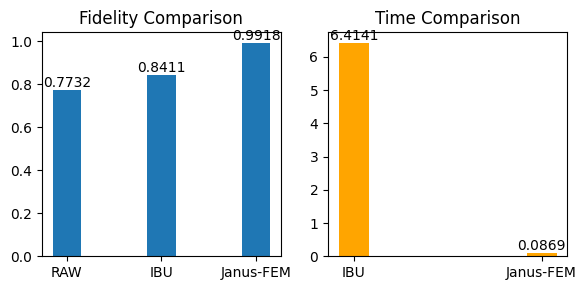

In [9]:
values_fid = [hellinger_fidelity(out_ideal,output_noise), hellinger_fidelity(out_ideal,outout_ibu).item(), hellinger_fidelity(out_ideal,output_fem)]
labels_fid = ['RAW', 'IBU', 'Janus-FEM']

bar_width = 0.3

fig, axs = plt.subplots(1, 2, figsize=(6, 3))

axs[0].bar(labels_fid, values_fid, width=bar_width)
axs[0].set_title('Fidelity Comparison')
for i, value in enumerate(values_fid):
    axs[0].text(i, value, '{:.4f}'.format(value), ha='center', va='bottom')

values_t = [t_ibu, t_fem]
labels_t = [ 'IBU', 'Janus-FEM']

axs[1].bar(labels_t, values_t, width=0.16, color='orange')
axs[1].set_title('Time Comparison')

for i, value in enumerate(values_t):
    axs[1].text(i, value, '{:.4f}'.format(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

**References**



<div><a name="R1"></a>
[1] Philip Krantz, Morten Kjaergaard, et al. A quantum engineer’s guide to
superconducting qubits[J]. Applied Physics Reviews, 2019.
</div>


<div><a name="R2"></a>
[2] Sergey Bravyi, Sarah Sheldon, et al. Mitigating measurement errors in multiqubit experi-
ments[J]. Physical Review A, 2021.
</div>

<div><a name="R3"></a>
[2] P. Rebentrost, M. Mohseni, et al. Quantum support vector
machine for big feature and big data classification[J]. Physical Review
Letters, 2013.
</div>


<div><a name="R4"></a>
[4] Satzinger K J, Liu Y J, Smith A, et al. Realizing topologically ordered states on a quantum processor[J]. Science, 2021.
</div>

<div><a name="R5"></a>
[5] Nation P D, Kang H, Sundaresan N, et al. Scalable mitigation of measurement errors on quantum computers[J]. PRX Quantum, 2021.
</div>

<div><a name="R6"></a>
[6] Bravyi S, Sheldon S, Kandala A, et al. Mitigating measurement errors in multiqubit experiments[J]. Physical Review A, 2021.
</div>

<div><a name="R7"></a>
[7]  Beijing Academy of Quantum Information Sciences. Quafu quantum cloud computing platform. https://quafu.baqis.ac.cn/
</div>